In [1]:
import random
from dataclasses import dataclass
from typing import Any, List, Dict, Optional, Union, Tuple

import cv2
import torch
import requests
import numpy as np
from PIL import Image
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from transformers import AutoModelForMaskGeneration, AutoProcessor, pipeline
import pandas as pd

@dataclass
class BoundingBox:
    xmin: int
    ymin: int
    xmax: int
    ymax: int

    @property
    def xyxy(self) -> List[float]:
        return [self.xmin, self.ymin, self.xmax, self.ymax]

@dataclass
class DetectionResult:
    score: float
    label: str
    box: BoundingBox
    mask: Optional[np.array] = None

    @classmethod
    def from_dict(cls, detection_dict: Dict) -> 'DetectionResult':
        return cls(score=detection_dict['score'],
                   label=detection_dict['label'],
                   box=BoundingBox(xmin=detection_dict['box']['xmin'],
                                   ymin=detection_dict['box']['ymin'],
                                   xmax=detection_dict['box']['xmax'],
                                   ymax=detection_dict['box']['ymax']))
    
def annotate(image: Union[Image.Image, np.ndarray], detection_results: List[DetectionResult]) -> np.ndarray:
    # Convert PIL Image to OpenCV format
    image_cv2 = np.array(image) if isinstance(image, Image.Image) else image
    image_cv2 = cv2.cvtColor(image_cv2, cv2.COLOR_RGB2BGR)

    # Iterate over detections and add bounding boxes and masks
    for detection in detection_results:
        label = detection.label
        score = detection.score
        box = detection.box
        mask = detection.mask

        # Sample a random color for each detection
        color = np.random.randint(0, 256, size=3)

        # Draw bounding box
        cv2.rectangle(image_cv2, (box.xmin, box.ymin), (box.xmax, box.ymax), color.tolist(), 2)
        cv2.putText(image_cv2, f'{label}: {score:.2f}', (box.xmin, box.ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 2.0, color.tolist(), 2)

        # If mask is available, apply it
        if mask is not None:
            # Convert mask to uint8
            mask_uint8 = (mask * 255).astype(np.uint8)
            contours, _ = cv2.findContours(mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            cv2.drawContours(image_cv2, contours, -1, color.tolist(), 2)

    return cv2.cvtColor(image_cv2, cv2.COLOR_BGR2RGB)

def plot_detections(
    image: Union[Image.Image, np.ndarray],
    detections: List[DetectionResult],
    save_name: Optional[str] = None
) -> None:
    annotated_image = annotate(image, detections)
    plt.imshow(annotated_image)
    plt.axis('off')
    if save_name:
        plt.savefig(save_name, bbox_inches='tight')
    plt.show()

def mask_to_polygon(mask: np.ndarray) -> List[List[int]]:
    # Find contours in the binary mask
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Find the contour with the largest area
    largest_contour = max(contours, key=cv2.contourArea)

    # Extract the vertices of the contour
    polygon = largest_contour.reshape(-1, 2).tolist()

    return polygon

def polygon_to_mask(polygon: List[Tuple[int, int]], image_shape: Tuple[int, int]) -> np.ndarray:
    """
    Convert a polygon to a segmentation mask.

    Args:
    - polygon (list): List of (x, y) coordinates representing the vertices of the polygon.
    - image_shape (tuple): Shape of the image (height, width) for the mask.

    Returns:
    - np.ndarray: Segmentation mask with the polygon filled.
    """
    # Create an empty mask
    mask = np.zeros(image_shape, dtype=np.uint8)

    # Convert polygon to an array of points
    pts = np.array(polygon, dtype=np.int32)

    # Fill the polygon with white color (255)
    cv2.fillPoly(mask, [pts], color=(255,))

    return mask

def load_image(image_str: str) -> Image.Image:
    if image_str.startswith("http"):
        image = Image.open(requests.get(image_str, stream=True).raw).convert("RGB")
    else:
        image = Image.open(image_str).convert("RGB")

    return image

def get_boxes(results: DetectionResult) -> List[List[List[float]]]:
    boxes = []
    for result in results:
        xyxy = result.box.xyxy
        boxes.append(xyxy)

    return [boxes]

def refine_masks(masks: torch.BoolTensor, polygon_refinement: bool = False) -> List[np.ndarray]:
    masks = masks.cpu().float()
    masks = masks.permute(0, 2, 3, 1)
    masks = masks.mean(axis=-1)
    masks = (masks > 0).int()
    masks = masks.numpy().astype(np.uint8)
    masks = list(masks)

    if polygon_refinement:
        for idx, mask in enumerate(masks):
            shape = mask.shape
            polygon = mask_to_polygon(mask)
            mask = polygon_to_mask(polygon, shape)
            masks[idx] = mask

    return masks

def detect(
    image: Image.Image,
    labels: List[str],
    threshold: float = 0.3,
    detector_id: Optional[str] = None
) -> List[Dict[str, Any]]:
    """
    Use Grounding DINO to detect a set of labels in an image in a zero-shot fashion.
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"
    detector_id = detector_id if detector_id is not None else "IDEA-Research/grounding-dino-tiny"
    object_detector = pipeline(model=detector_id, task="zero-shot-object-detection", device=device)

    labels = [label if label.endswith(".") else label+"." for label in labels]

    results = object_detector(image,  candidate_labels=labels, threshold=threshold)
    results = [DetectionResult.from_dict(result) for result in results]

    return results

def segment(
    image: Image.Image,
    detection_results: List[Dict[str, Any]],
    polygon_refinement: bool = False,
    segmenter_id: Optional[str] = None
) -> List[DetectionResult]:
    """
    Use Segment Anything (SAM) to generate masks given an image + a set of bounding boxes.
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"
    segmenter_id = segmenter_id if segmenter_id is not None else "facebook/sam-vit-base"

    segmentator = AutoModelForMaskGeneration.from_pretrained(segmenter_id).to(device)
    processor = AutoProcessor.from_pretrained(segmenter_id)

    boxes = get_boxes(detection_results)
    inputs = processor(images=image, input_boxes=boxes, return_tensors="pt").to(device)

    outputs = segmentator(**inputs)
    masks = processor.post_process_masks(
        masks=outputs.pred_masks,
        original_sizes=inputs.original_sizes,
        reshaped_input_sizes=inputs.reshaped_input_sizes
    )[0]

    masks = refine_masks(masks, polygon_refinement)

    for detection_result, mask in zip(detection_results, masks):
        detection_result.mask = mask

    return detection_results

def grounded_segmentation(
    image: Union[Image.Image, str],
    labels: List[str],
    threshold: float = 0.3,
    polygon_refinement: bool = False,
    detector_id: Optional[str] = None,
    segmenter_id: Optional[str] = None
) -> Tuple[np.ndarray, List[DetectionResult]]:
    if isinstance(image, str):
        image = load_image(image)

    detections = detect(image, labels, threshold, detector_id)
    detections = segment(image, detections, polygon_refinement, segmenter_id)

    return np.array(image), detections

def compute_union_area(masks: List[np.ndarray]) -> int:
    if not masks:
        return 0
    # Stack masks to create a 3D array and compute the logical OR across all masks
    union_mask = np.logical_or.reduce(np.stack(masks, axis=0))
    return np.sum(union_mask)

def grounded_segmentation_area(
    image: Union[Image.Image, str],
    labels: List[str],
    threshold: float = 0.3,
    polygon_refinement: bool = False,
    detector_id: Optional[str] = None,
    segmenter_id: Optional[str] = None
) -> int:
    if isinstance(image, str):
        image = load_image(image)

    detections = detect(image, labels, threshold, detector_id)
    detections = segment(image, detections, polygon_refinement, segmenter_id)

    # Extract masks from detections and compute the union area
    masks = [detection.mask for detection in detections if detection.mask is not None]
    union_area = compute_union_area(masks)
    for detection in detections:
        print(f"{detection.label}: {np.sum(detection.mask) / union_area}")
    return union_area

def sample_frames(start_frame, end_frame, num_samples=5):
    return np.linspace(start_frame, end_frame, num=num_samples, dtype=int)

def process_narr(take_name, cam_id, start_frame, end_frame, nouns, num_samples=5):
    frame_numbers = sample_frames(start_frame, end_frame, num_samples)
    union_areas = []

    video_path = f'/datasets01/egoexo4d/v2/takes/{take_name}/frame_aligned_videos/{cam_id}.mp4'
    cap = cv2.VideoCapture(video_path)
    for frame_number in frame_numbers:
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)  # Set the current frame position
        ret, frame_cv2 = cap.read()
        
        if not ret:
            print(f"Failed to read frame {frame_number} from video {video_path}")
            continue
        
        # Convert OpenCV frame to PIL Image
        frame = cv2.cvtColor(frame_cv2, cv2.COLOR_BGR2RGB)
        frame = Image.fromarray(frame)
        area = grounded_segmentation_area(
            image=frame,
            labels=nouns,
            threshold=0.3,
            polygon_refinement=True,
            detector_id="IDEA-Research/grounding-dino-tiny",
            segmenter_id="facebook/sam-vit-base"
        )
        image_array, detections = grounded_segmentation(
            image=frame,
            labels=nouns,
            threshold=0.3,
            polygon_refinement=True,
            detector_id="IDEA-Research/grounding-dino-tiny",
            segmenter_id="facebook/sam-vit-base"
        )
        plot_detections(image_array, detections)
        union_areas.append(area)
    cap.release()  # Release the video capture object
    # Compute the mean of the union areas
    mean_area = np.mean(union_areas) if union_areas else 0
    return mean_area

csv_file = '/private/home/arjunrs1/CliMer/data/egoexo4d/egoexo4d_exos_keysteps_test.csv'
data = pd.read_csv(csv_file)

['tube', 'carton']
['tube', 'carton', 'hand']
Video name:
georgiatech_bike_06_10_cam01
take name:
georgiatech_bike_06_10
cam id:
cam01
nouns:
['tube', 'carton', 'hand']


hand.: 22.220565653679962
hand.: 31.70615648323394
tube.: 12.334303467485627
carton.: 78.71219155090526
carton.: 32.66230403885298
carton.: 12.827554190622433
carton.: 91.10113202156911


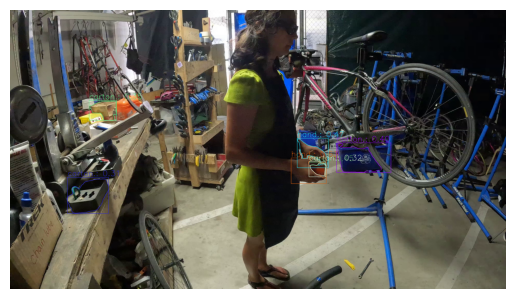

hand.: 6.175458809974487
carton.: 35.992264011192496
hand.: 8.780511892025348
carton.: 14.979754752695252
carton.: 146.68323594765863
carton.: 42.38877458645379


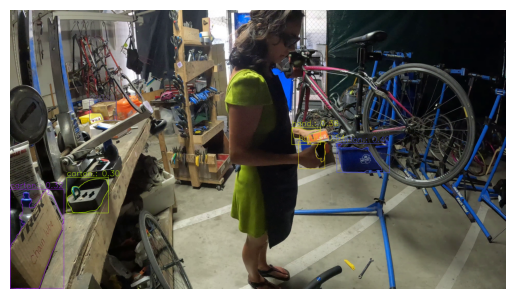

carton.: 29.900935157557676
carton.: 12.539719179826795
carton.: 123.18071828833418
hand.: 3.5908958591077798
hand.: 12.750811895058584
carton.: 34.11293073648206
carton.: 7.316914252965577
carton.: 33.165913143148245


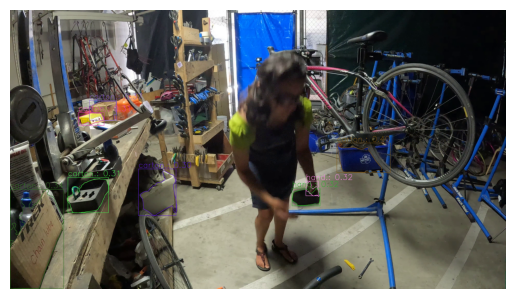

hand.: 15.965661903630275
carton.: 30.814147465112505
carton.: 12.863127604356613
carton.: 126.44612231740975
carton.: 34.06247867692213
carton.: 7.576639553515338
carton.: 22.327927173306918
hand.: 4.9606949499892945


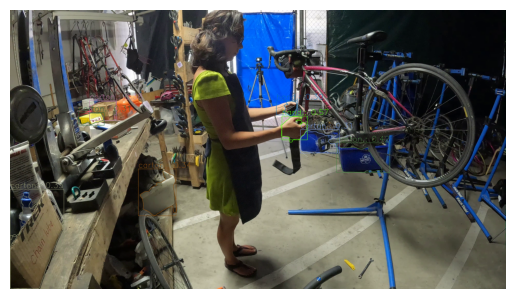

KeyboardInterrupt: 

In [8]:
results = {}
for index, row in data.iterrows():
    video_name = row['video_id']
    start_frame = row['start_frame']
    end_frame = row['end_frame']
    nouns = eval(row['noun_class'])
    if "hand" not in nouns:
        if "hands" not in nouns:
            nouns.append("hand")
    take_name = video_name.rsplit("_", 1)[0] if "aria" not in video_name else video_name.rsplit("_", 2)[0]
    cam_id = video_name.rsplit("_", 1)[1] if "aria" not in video_name else "_".join(video_name.rsplit("_", 2)[1:])
    print("Video name:")
    print(video_name)
    print("take name:")
    print(take_name)
    print("cam id:")
    print(cam_id)
    print("nouns:")
    print(nouns)

    mean_area = process_narr(take_name, cam_id, start_frame, end_frame, nouns)
    results[video_name] = mean_area
    break
print(results)